In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [ ]:
def sample_init(d,r,nnode):
    p = {}
    p['U'] = np.random.normal(0,1,(d,r))
    p['X0'] = np.random.normal(0,1,(d,r,nnode))
    return(p)

def dist_opt(p, s):
    
    M = p['U']@p['U'].transpose()

    t = s['gd_stepsize']
    pull = s['pull_force']
    nnode = s['num_nodes']
    
    Xs = p['X0'].copy()
    center = np.mean(Xs, axis=2)
    
    k = 0
    tr = np.zeros((s['max_iter'],nnode+1))
    
    while k < s['max_iter']:
        #evaluate objective function
        fmin = np.Inf
        argmin = -1
        for i in range(0,nnode):
            obj = 0.25*np.linalg.norm(Xs[:,:,i]@Xs[:,:,i].transpose() - M, ord='fro')**2
            tr[k,i] = obj
            if obj < fmin:
                fmin = obj
                argmin = i
        tr[k,nnode] = fmin
        
        if s['alg'] == 'easgd':
            center = (1 - nnode*t*pull)*center + nnode*t*pull*np.mean(Xs, axis=2)
        elif s['alg'] == 'lgd':
            center = Xs[:,:,argmin]
        
        #iterative step
        for i in range(0,nnode):
            grad = (Xs[:,:,i]@Xs[:,:,i].transpose() - M)@Xs[:,:,i]
            if s['alg'] in ['easgd', 'lgd']:
                Xs[:,:,i] = (1 - t*pull)*Xs[:,:,i] + t*pull*center - t*grad
            elif s['alg'] == 'pargd':
                Xs[:,:,i] = Xs[:,:,i] - t*grad
        
        k = k + 1
    return(tr)

def run_acc_trials(s, d, r, ntests):
    
    easgd_prog = np.zeros((s['max_iter'], ntests))
    lgd_prog = np.zeros((s['max_iter'], ntests))
    
    nnode = s['num_nodes']
    
    for i in range(0,ntests):
        p = sample_init(d,r,nnode)
        
        s['alg'] = 'easgd'
        out = dist_opt(p,s)
        easgd_prog[:,i] = out[:,nnode]
        
        s['alg'] = 'lgd'
        out = dist_opt(p,s)
        lgd_prog[:,i] = out[:,nnode]
    
    return([easgd_prog, lgd_prog])

In [ ]:
s = {}
s['num_nodes'] = 8
s['pull_force'] = 1/5

In [ ]:
#d = 1000, ranks = 1,10,50,100
s['gd_stepsize'] = 5e-4

np.random.seed(212)
s['max_iter'] = 50
rank1 = run_acc_trials(s,1000,1,10)
pickle.dump(rank1, open("rank1.pickle", "wb"))

np.random.seed(917)
s['max_iter'] = 50
rank10 = run_acc_trials(s,1000,10,10)
pickle.dump(rank10, open("rank10.pickle", "wb"))

np.random.seed(332)
s['max_iter'] = 50
rank50 = run_acc_trials(s,1000,50,10)
pickle.dump(rank50, open("rank50.pickle", "wb"))

np.random.seed(646)
s['max_iter'] = 50
rank100 = run_acc_trials(s,1000,100,10)
pickle.dump(rank100, open("rank100.pickle", "wb"))

#originally ran 100,100,150,150 trials

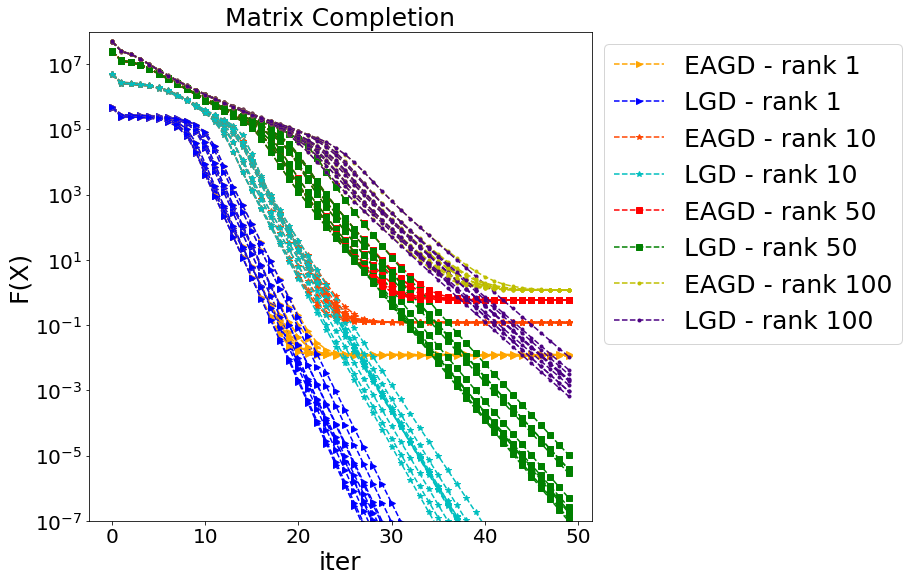

In [2]:
rank1 = pickle.load(open("rank1.pickle", "rb"))
rank10 = pickle.load(open("rank10.pickle", "rb"))
rank50 = pickle.load(open("rank50.pickle", "rb"))
rank100 = pickle.load(open("rank100.pickle", "rb"))


markersize = 6
plt.rc('axes', titlesize=25)
plt.rc('xtick', labelsize=20)
plt.rc('ytick',labelsize=20)
plt.rc('axes', labelsize=25)
plt.rc('legend',fontsize=25) 

plt.figure(figsize=(9,9))
plt.title('Matrix Completion')
plt.xlabel('iter')
plt.ylabel('F(X)')
plt.yscale('log')
plt.ylim((1e-7, 1e8))

#plt.subplot(221)
plt.plot(np.linspace(0,49,50), rank1[0][0:50,0], color="orange", linestyle='dashed', marker='>', markersize=markersize, label="EAGD - rank 1")
plt.plot(np.linspace(0,49,50), rank1[1][0:50,0], 'b>--', markersize=markersize, label="LGD - rank 1")
for i in range(1,10):
    plt.plot(np.linspace(0,49,50), rank1[0][0:50,i], color="orange", linestyle='dashed', marker='>', markersize=markersize)
    plt.plot(np.linspace(0,49,50), rank1[1][0:50,i], 'b>--', markersize=markersize)

#plt.subplot(222)
#plt.xlabel('iter')
#plt.yscale('log')
#plt.title('Rank 10')
plt.plot(np.linspace(0,49,50), rank10[0][0:50,0], color="orangered", linestyle='dashed', marker='*', markersize=markersize, label="EAGD - rank 10")
plt.plot(np.linspace(0,49,50), rank10[1][0:50,0], "c*--", markersize=markersize, label="LGD - rank 10")
for i in range(1,10):
    plt.plot(np.linspace(0,49,50), rank10[0][0:50,i], color="orangered", linestyle='dashed', marker='*', markersize=markersize)
    plt.plot(np.linspace(0,49,50), rank10[1][0:50,i], "c*--", markersize=markersize)

#ax = plt.subplot(223)
#plt.xlabel('iter')
#plt.yscale('log')
#plt.title('Rank 50')
plt.plot(np.linspace(0,49,50), rank50[0][0:50,0], "rs--", markersize=markersize, label='EAGD - rank 50')
plt.plot(np.linspace(0,49,50), rank50[1][0:50,0], "gs--", markersize=markersize, label='LGD - rank 50')
for i in range(1,10):
    plt.plot(np.linspace(0,49,50), rank50[0][0:50,i], "rs--", markersize=markersize)
    plt.plot(np.linspace(0,49,50), rank50[1][0:50,i], "gs--", markersize=markersize)

#plt.subplot(224)
#plt.xlabel('iter')
#plt.yscale('log')
#plt.title('Rank 100')
plt.plot(np.linspace(0,49,50), rank100[0][0:50,0], "y.--", markersize=markersize, label="EAGD - rank 100")
plt.plot(np.linspace(0,49,50), rank100[1][0:50,0], color="indigo", linestyle='dashed', marker='.', markersize=markersize, label="LGD - rank 100")
for i in range(1,10):
    plt.plot(np.linspace(0,49,50), rank100[0][0:50,i], "y.--", markersize=markersize)
    plt.plot(np.linspace(0,49,50), rank100[1][0:50,i], color="indigo", linestyle='dashed', marker='.', markersize=markersize)
 
lgd = plt.legend(bbox_to_anchor=(1,1)) #
plt.savefig('matrix_completion.png', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')